# Custom loss functions Pytorch

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

We going to exemplify how to implement a custom loss function on MLP using the Pytorch Library.

**Data Type at Entry:** Torch tensors.

**Data Type at Output:** Torch tensors.

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

In [3]:
def creation_batchs(n_batchs, X_train, y_train):

  N_train = len(X_train)
  N_batch = int(N_train/n_batchs) + 1

  all_X_train = []
  all_y_train = []

  for i in range(n_batchs):

    all_X_train.append(X_train[i*N_batch: (i+1)*N_batch].copy())
    all_y_train.append(y_train[i*N_batch: (i+1)*N_batch].copy())

  return all_X_train, all_y_train

### Start time of execution

In [4]:
start = time.time()

# 1. Regresion Problem

### i. Creacion of Dataset

In [5]:
X = [(i*0.1 - 20) for i in range(1, 400 + 1)]

In [6]:
y = [x**2 for x in X]

In [7]:
df = pd.DataFrame({'X': X, 'y': y})

In [8]:
df['X'] = df['X'].astype('float32')
df['y'] = df['y'].astype('float32')

In [9]:
X = df[['X']].copy()
y = df['y'].copy()

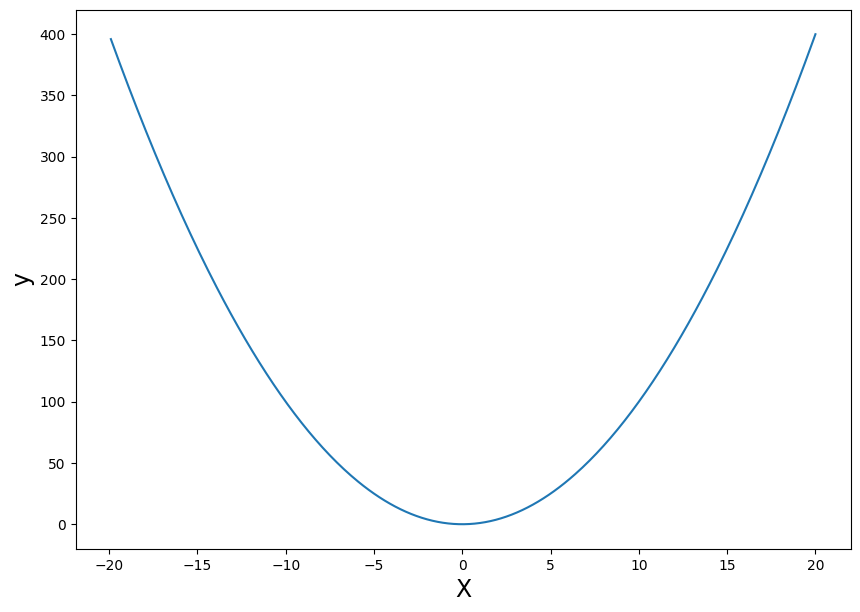

In [10]:
plt.figure(figsize = (10, 7))
plt.xlabel('X', fontsize = 17)
plt.ylabel('y', fontsize = 17)
plt.plot(X, y)
plt.show()

### ii. Split

In [11]:
n_batchs = 2

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

In [14]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [15]:
y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train = (y_train - y_train_mean)/y_train_std
y_val = (y_val - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

In [16]:
all_X_train, all_y_train = creation_batchs(n_batchs, X_train, y_train)

In [17]:
for i in range(n_batchs):
  all_X_train[i] = torch.tensor(np.array(all_X_train[i]))
  all_y_train[i] = torch.tensor(np.array(all_y_train[i]))

X_train = torch.tensor(np.array(X_train))
y_train = torch.tensor(np.array(y_train))

X_val = torch.tensor(np.array(X_val))
y_val = torch.tensor(np.array(y_val))

X_test = torch.tensor(np.array(X_test))
y_test = torch.tensor(np.array(y_test))

### iii. Creation of model

In [18]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size):
        super(MLP, self).__init__()

        #----------------------------------------------------------------------

        self.input_size = input_size

        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2

        self.output_size = output_size

        #----------------------------------------------------------------------

        self.fc_entry = nn.Linear(self.input_size, self.hidden_dim_1)

        self.fc_1 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.fc_2 = nn.Linear(self.hidden_dim_2, self.output_size)

        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.ReLU()

        #----------------------------------------------------------------------


    def forward(self, x):

        out = self.fc_entry(x)
        out = self.activation_1(out)

        out = self.fc_1(out)
        out = self.activation_2(out)

        out = self.fc_2(out)

        return out

# Custom Loss Function

In [19]:
def my_loss(output, target):
    loss = torch.mean(torch.abs(output - target))
    return loss

# Model

In [20]:
class Model():

  def __init__(self, input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr):

    self.input_size = input_size
    self.hidden_dim_1 = hidden_dim_1
    self.hidden_dim_2 = hidden_dim_2
    self.output_size = output_size

    self.n_epochs = n_epochs
    self.lr = lr

    self.model = MLP(input_size, hidden_dim_1, hidden_dim_2, output_size)


  def train(self):

    start_train = time.time()

    #----------------------------------------------------------------------

    criterion = my_loss
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)

    #----------------------------------------------------------------------

    all_train_loss = []
    all_val_loss = []
    all_epochs = []

    #----------------------------------------------------------------------

    for epoch in range(1, self.n_epochs + 1):

      # 1. Train

      self.model.train()

      loss_train_epoch = 0

      for n_iter in range(n_batchs):

        X_train_batch = all_X_train[n_iter]
        y_train_batch = all_y_train[n_iter]

        optimizer.zero_grad() # Clears existing gradients

        out_train_batch = self.model(X_train_batch)
        out_train_batch = torch.reshape(out_train_batch, (-1, ))

        loss_train_batch = criterion(out_train_batch, y_train_batch)

        loss_train_batch.backward()
        optimizer.step() # Updates the weights accordingly

        loss_train_epoch = loss_train_epoch + loss_train_batch.item()

      loss_train_epoch = loss_train_epoch/len(X_train)

      all_train_loss.append(loss_train_epoch)
      all_epochs.append(epoch)

      # 2. Validation

      self.model.eval()

      out_val = self.model(X_val)
      out_val = torch.reshape(out_val, (-1, ))

      loss_val = criterion(out_val, y_val).item()/len(X_val)

      all_val_loss.append(loss_val)

    #----------------------------------------------------------------------

    end_train = time.time()

    self.all_epochs = all_epochs

    self.all_train_loss = all_train_loss
    self.all_val_loss = all_val_loss

    return print_time_execution(start_train, end_train, 'in train the model')


  def plot_train(self):

    plt.figure(figsize = (10, 7))
    plt.title('Normal scale')
    plt.plot(self.all_epochs, self.all_train_loss, label = 'train', color = 'blue')
    plt.plot(self.all_epochs, self.all_val_loss, label = 'val', color = 'red')
    plt.legend()
    plt.show()

    print('\n')
    print('\n')
    print('\n')

    plt.figure(figsize = (10, 7))
    plt.title('Log scale')
    plt.plot(self.all_epochs, np.log(np.array(self.all_train_loss)), label = 'train', color = 'blue')
    plt.plot(self.all_epochs, np.log(np.array(self.all_val_loss)), label = 'val', color = 'red')
    plt.legend()
    plt.show()


  def evaluation_val_set(self):

    criterion = nn.MSELoss()

    self.model.eval()

    out_val = self.model(X_val)
    out_val = torch.reshape(out_val, (-1, ))

    loss_val = criterion(out_val, y_val).item()/len(X_val)

    return loss_val


### iv. Hyperparameter Tuning Jobs

In [21]:
input_size = 1
output_size = 1

all_hidden_dim_1 = [(i*2) for i in range(1, 5 + 1)]
all_hidden_dim_2 = [(i*2) for i in range(1, 5 + 1)]
all_n_epochs = [(i*100) for i in range(1, 5 + 1)]
all_lr = [(i*0.01) for i in range(1, 5 + 1)]

all_params = []

for hidden_dim_1 in all_hidden_dim_1:
  for hidden_dim_2 in all_hidden_dim_2:
    for n_epochs in all_n_epochs:
      for lr in all_lr:
        all_params.append({'hidden_dim_1': hidden_dim_1, 'hidden_dim_2': hidden_dim_2, 'n_epochs': n_epochs, 'lr': lr})

In [22]:
hidden_dim_1_col = []
hidden_dim_2_col = []

n_epochs_col = []
lr_col = []

loss_val_col = []

c = 0

start_iter = time.time()

m = 10

for params in all_params:

  c = c + 1

  hidden_dim_1 = params['hidden_dim_1']
  hidden_dim_2 = params['hidden_dim_2']

  n_epochs = params['n_epochs']
  lr = params['lr']

  model = Model(input_size, hidden_dim_1, hidden_dim_2, output_size, n_epochs, lr)
  _ = model.train()
  loss_val = model.evaluation_val_set()

  hidden_dim_1_col.append(hidden_dim_1)
  hidden_dim_2_col.append(hidden_dim_2)

  n_epochs_col.append(n_epochs)
  lr_col.append(lr)

  loss_val_col.append(loss_val)

  if (c % m) == 0:

    end_iter = time.time()
    print(f'c = {c}')
    print(print_time_execution(start_iter, end_iter, f'execute {m} iterations'))
    print('-'*70)
    start_iter = time.time()

c = 10
execute 10 iterations it takes 0 hours, 0 mins and 8 segs.
----------------------------------------------------------------------
c = 20
execute 10 iterations it takes 0 hours, 0 mins and 17 segs.
----------------------------------------------------------------------
c = 30
execute 10 iterations it takes 0 hours, 0 mins and 8 segs.
----------------------------------------------------------------------
c = 40
execute 10 iterations it takes 0 hours, 0 mins and 7 segs.
----------------------------------------------------------------------
c = 50
execute 10 iterations it takes 0 hours, 0 mins and 13 segs.
----------------------------------------------------------------------
c = 60
execute 10 iterations it takes 0 hours, 0 mins and 4 segs.
----------------------------------------------------------------------
c = 70
execute 10 iterations it takes 0 hours, 0 mins and 10 segs.
----------------------------------------------------------------------
c = 80
execute 10 iterations it takes 

In [23]:
ht = pd.DataFrame()
ht['hidden_dim_1'] = hidden_dim_1_col
ht['hidden_dim_2'] = hidden_dim_2_col
ht['n_epochs'] = n_epochs_col
ht['lr'] = lr_col
ht['loss_val'] = loss_val_col

In [24]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt, _ = ht[ht['loss_val'] == ht['loss_val'].min()].iloc[0]

In [25]:
hidden_dim_1_opt = int(hidden_dim_1_opt)
hidden_dim_2_opt = int(hidden_dim_2_opt)
n_epochs_opt = int(n_epochs_opt)

In [26]:
hidden_dim_1_opt, hidden_dim_2_opt, n_epochs_opt, lr_opt

(10, 6, 200, 0.02)

### v. Definitive model

In [27]:
model = Model(input_size, hidden_dim_1_opt, hidden_dim_2_opt, output_size, n_epochs_opt, lr_opt)

In [28]:
model.train()

'in train the model it takes 0 hours, 0 mins and 0 segs.'

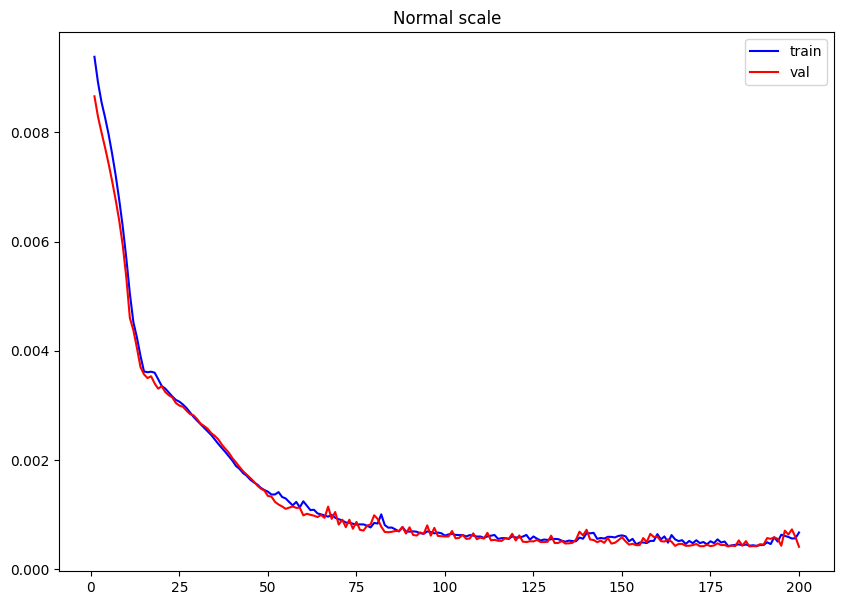

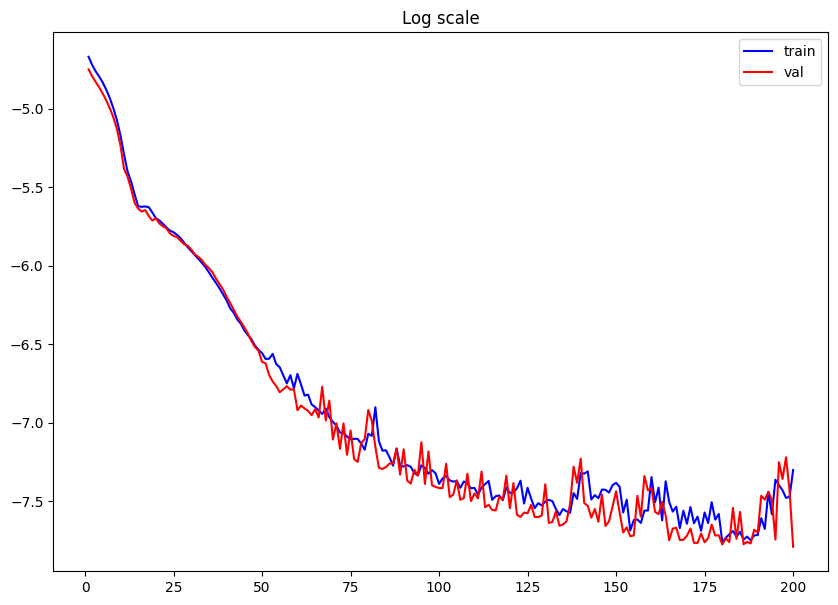

In [29]:
model.plot_train()

In [30]:
model_MLP = model.model

### vi. Performance Metrics

In [31]:
train_predict = model_MLP(X_train)
train_predict = torch.reshape(train_predict, (-1, ))
train_predict = list(train_predict.detach().cpu().numpy())

X_train_col = torch.reshape(X_train, (-1, ))
X_train_col = list(X_train_col.detach().cpu().numpy())

y_train_col = torch.reshape(y_train, (-1, ))
y_train_col = list(y_train_col.detach().cpu().numpy())

df_train = pd.DataFrame()
df_train['X'] = X_train_col
df_train['y'] = y_train_col
df_train['y_predict'] = train_predict

df_train['X'] = df_train['X']*X_train_std[0] + X_train_mean[0]
df_train['y'] = df_train['y']*y_train_std + y_train_mean
df_train['y_predict'] = df_train['y_predict']*y_train_std + y_train_mean

In [32]:
val_predict = model_MLP(X_val)
val_predict = torch.reshape(val_predict, (-1, ))
val_predict = list(val_predict.detach().cpu().numpy())

X_val_col = torch.reshape(X_val, (-1, ))
X_val_col = list(X_val_col.detach().cpu().numpy())

y_val_col = torch.reshape(y_val, (-1, ))
y_val_col = list(y_val_col.detach().cpu().numpy())

df_val = pd.DataFrame()
df_val['X'] = X_val_col
df_val['y'] = y_val_col
df_val['y_predict'] = val_predict

df_val['X'] = df_val['X']*X_train_std[0] + X_train_mean[0]
df_val['y'] = df_val['y']*y_train_std + y_train_mean
df_val['y_predict'] = df_val['y_predict']*y_train_std + y_train_mean

In [33]:
test_predict = model_MLP(X_test)
test_predict = torch.reshape(test_predict, (-1, ))
test_predict = list(test_predict.detach().cpu().numpy())

X_test_col = torch.reshape(X_test, (-1, ))
X_test_col = list(X_test_col.detach().cpu().numpy())

y_test_col = torch.reshape(y_test, (-1, ))
y_test_col = list(y_test_col.detach().cpu().numpy())

df_test = pd.DataFrame()
df_test['X'] = X_test_col
df_test['y'] = y_test_col
df_test['y_predict'] = test_predict

df_test['X'] = df_test['X']*X_train_std[0] + X_train_mean[0]
df_test['y'] = df_test['y']*y_train_std + y_train_mean
df_test['y_predict'] = df_test['y_predict']*y_train_std + y_train_mean

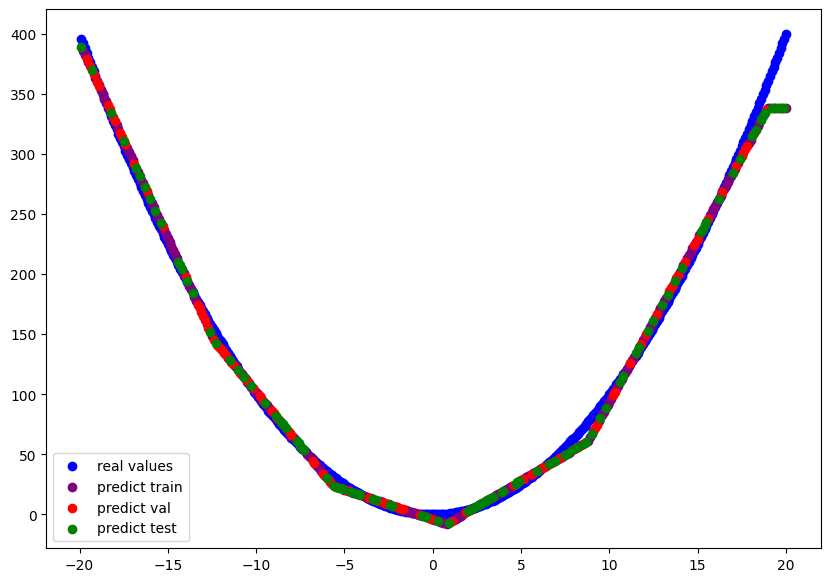

In [34]:
plt.figure(figsize = (10, 7))

plt.scatter(df_train['X'], df_train['y'], color = 'blue', label = 'real values')
plt.scatter(df_val['X'], df_val['y'], color = 'blue')
plt.scatter(df_test['X'], df_test['y'], color = 'blue')

plt.scatter(df_train['X'], df_train['y_predict'], color = 'purple', label = 'predict train')
plt.scatter(df_val['X'], df_val['y_predict'], color = 'red', label = 'predict val')
plt.scatter(df_test['X'], df_test['y_predict'], color = 'green', label = 'predict test')

plt.legend()
plt.show()

In [35]:
mae_train = round(abs(df_train['y_predict'] - df_train['y']).mean(), 2)
mae_val = round(abs(df_val['y_predict'] - df_val['y']).mean(), 2)
mae_test = round(abs(df_test['y_predict'] - df_test['y']).mean(), 2)

print('MAE train: ', mae_train)
print('MAE val: ', mae_val)
print('MAE test: ', mae_test)

MAE train:  4.97
MAE val:  4.91
MAE test:  6.22


### vii. Explainability

In [36]:
!pip install -q shap

In [37]:
import shap

In [38]:
def MLP_predict(df_X):

  df_X_tensor = torch.tensor(np.array(df_X))
  y_pred = model_MLP(df_X_tensor)
  y_pred = torch.reshape(y_pred, (-1, 1))
  y_pred = y_pred.detach().cpu().numpy()
  y_pred = y_pred[:, 0]

  return y_pred

In [39]:
explainer = shap.KernelExplainer(MLP_predict, df_test[['X']])

In [40]:
shap_values = explainer.shap_values(df_test[['X']])

  0%|          | 0/100 [00:00<?, ?it/s]

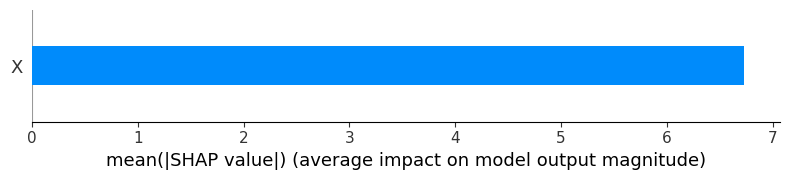

In [41]:
shap.summary_plot(shap_values, df_test[['X']], plot_type = "bar")

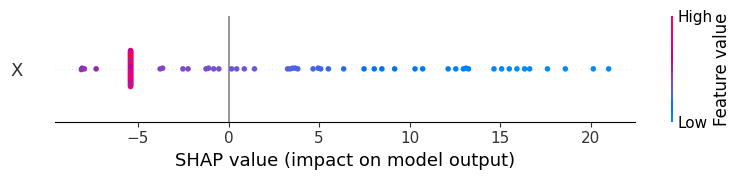

In [42]:
shap.summary_plot(shap_values, df_test[['X']])

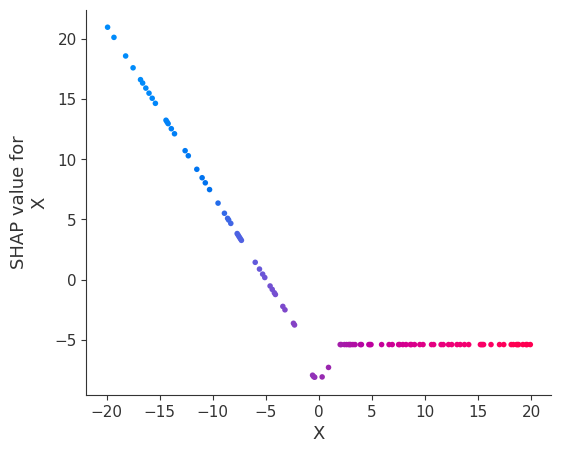

In [43]:
for name in ['X']:
    shap.dependence_plot(name, shap_values, df_test[['X']])

### End time of execution

In [44]:
end = time.time()

In [45]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 0 hours, 9 mins and 51 segs.
